# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/'

os.system("mkdir -p "+ plotDir)

0

# Signal part

In [81]:
masses = np.array([127, 150, 175, 200, 250, 300, 400])
# masses = np.array([ 200 ])


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/MC_Fall17/normalized/'
# file names
fnames = {}
# get all the trees
tree = OrderedDict()

for mass in masses:
    fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl1000_ev100000_1pb_weighted.root'
#     fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl10000_ev100000_1pb_weighted.root'

    print(home_dir+fnames[str(mass)])

    root_dir = uproot.open(home_dir+fnames[str(mass)])
    tree[str(mass)] = root_dir['SusyLLPSigEffTree']

    print ('Open ready')
    print(mass)
    print ('Tree ready')
    print(tree[str(mass)], tree)
    v = tree[str(mass)]
    jet_amax = v['met'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh127_pl1000_ev100000_1pb_weighted.root
Open ready
127
Tree ready
<TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8> OrderedDict([('127', <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>)])
[ 23.718494  55.69656  179.92311   51.420208  96.92844   18.01669
 140.20311   81.64856   34.34379   25.394737]
[5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05
 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05]
[5.6951445e-05]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh150_pl1000_ev100000_1pb_weighted.root
Open ready
150
Tree ready
<TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8> OrderedDict([('127', <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>), ('150', <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>)])
[ 23.946333  42.476227 389.88947   39.25008   91.36355   3

In [82]:
for k,v in tree.items():
    print(k,v)

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>


# 0 lep region

In [83]:
# trg_path=310
trg_path=467
#check trg sel, may not applied
# met_cut=200
met_cut=0


trg_jet_met = {}
trg_jet_hpt = {}
trg_jet_hid = {}

trg_jet_w = {} 
trg_jet_puw = {} 



for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
    hpt = v['gLLP_daughter_pt'].array()
    hid = v['gLLP_daughter_id'].array()

    hlt = v['HLTDecision'].array()[:,trg_path]


#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    


    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(met>met_cut, met>met_cut)    

#     met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_hlt_triggered)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_hpt[k] = hpt[met_trg_str]
    trg_jet_hid[k] = hid[met_trg_str]

    trg_jet_w[k] = weight[met_trg_str]
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]




    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))


127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
(61404,)
55630
55630
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
(59416,)
53629
53629
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
(56918,)
51243
51243
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
(55819,)
49915
49915
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
(53780,)
48075
48075
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
(51714,)
46099
46099
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
(49449,)
43851
43851


# H Pt

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
111260
111260
127 1
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
107258
107258
150 2
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
102486
102486
175 4
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
99830
99830
200 8
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
96150
96150
250 6
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
92198
92198
300 28
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
87702
87702
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/HPt.png has been created


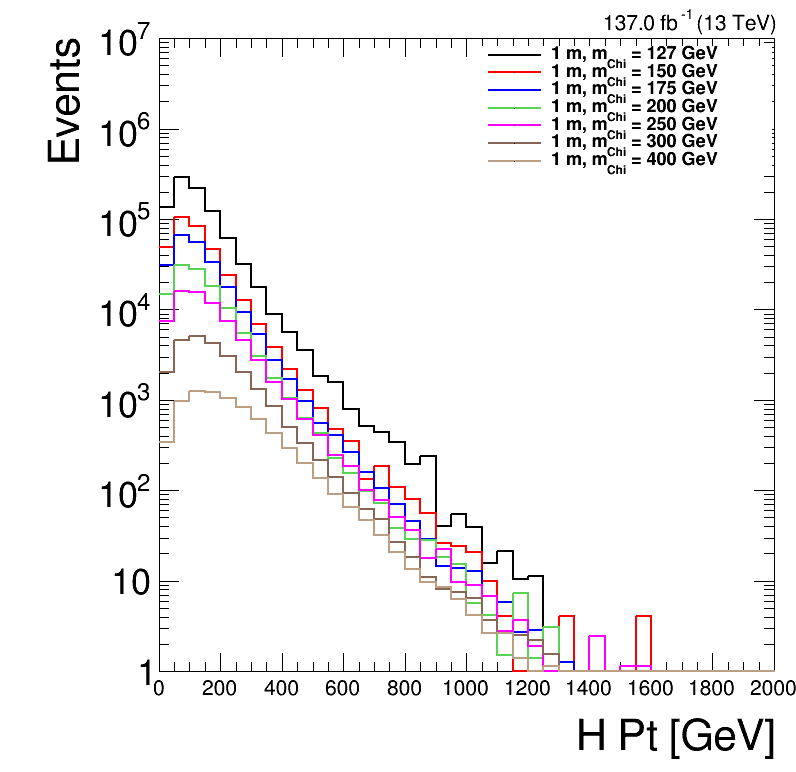

In [89]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    h_str = np.logical_and(1, trg_jet_hid[k]==25)
    var = trg_jet_hpt[k][h_str]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    print(len(var))
    print(len(ws))
    axis_set = ['H Pt [GeV]', 'Events']
    bin_set = [40,0,2000]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+7)
    print(k, std_color_list[i])
    ht[k].Draw("hist same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='HPt.png'
c.SaveAs(plotDir+outf)    
    

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
111260
111260
127 1
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
107258
107258
150 2
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
102486
102486
175 4
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
99830
99830
200 8
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
96150
96150
250 6
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
92198
92198
300 28
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
87702
87702
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/HPt_shape.png has been created


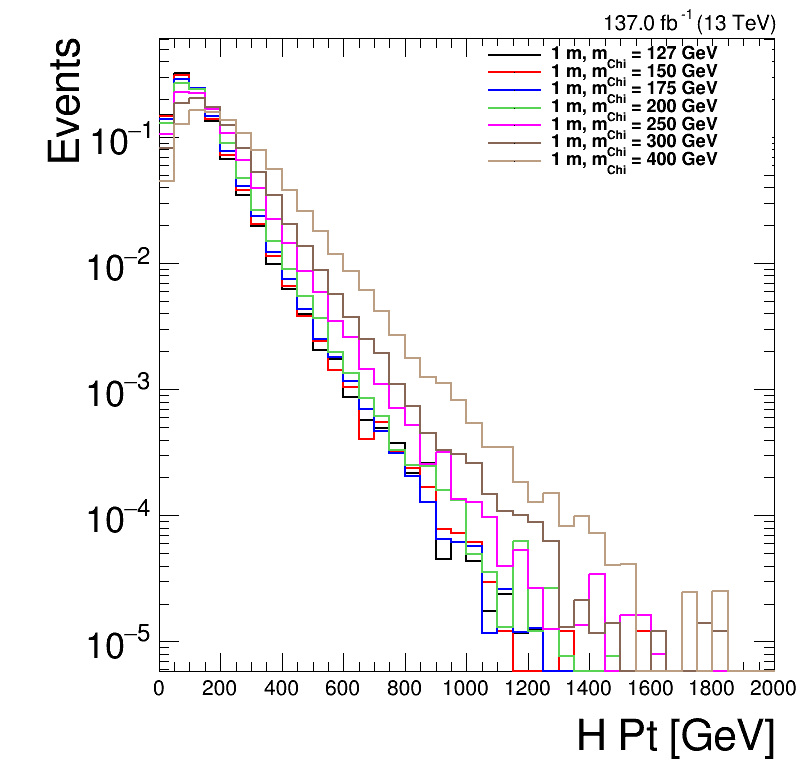

In [85]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    h_str = np.logical_and(1, trg_jet_hid[k]==25)
    var = trg_jet_hpt[k][h_str]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    print(len(var))
    print(len(ws))
    axis_set = ['H Pt [GeV]', 'Events']
    bin_set = [40,0,2000]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
#     ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
#     ht[k].Draw("hist E same")
    ht[k].DrawNormalized("hist same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='HPt_shape.png'
c.SaveAs(plotDir+outf)    
    

# MET

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
127 1
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
150 2
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
175 4
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
200 8
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
250 6
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
300 28
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/MET.png has been created


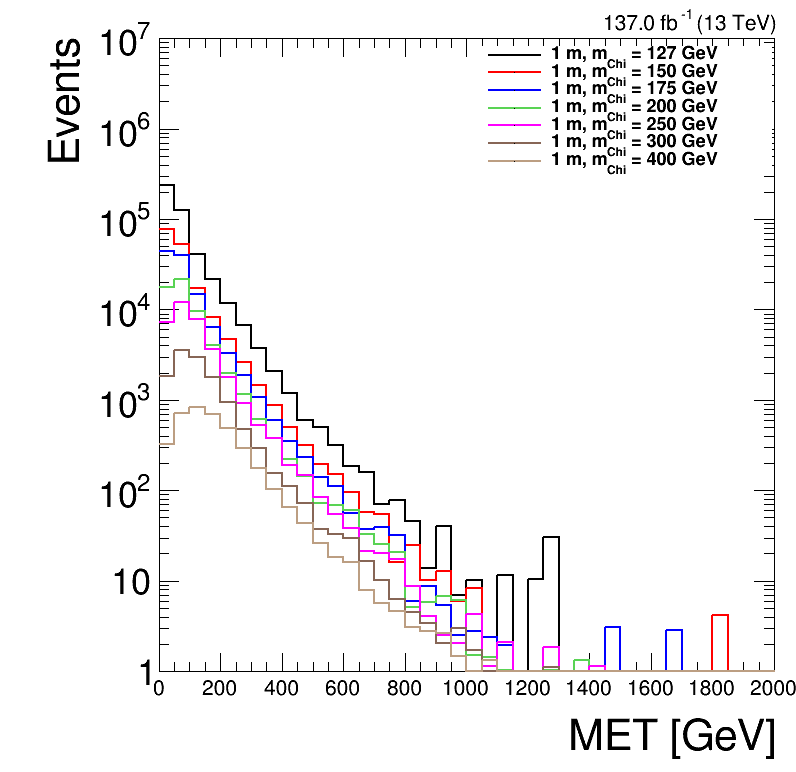

In [90]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = trg_jet_met[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['MET [GeV]', 'Events']
    bin_set = [40,0,2000]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+7)
    print(k, std_color_list[i])
    ht[k].Draw("histsame")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='MET.png'
c.SaveAs(plotDir+outf)    
    

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/MET_shape.png has been created


127 1
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
150 2
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
175 4
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
200 8
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
250 6
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
300 28
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
400 43
137.0 fb^{-1} (13 TeV)


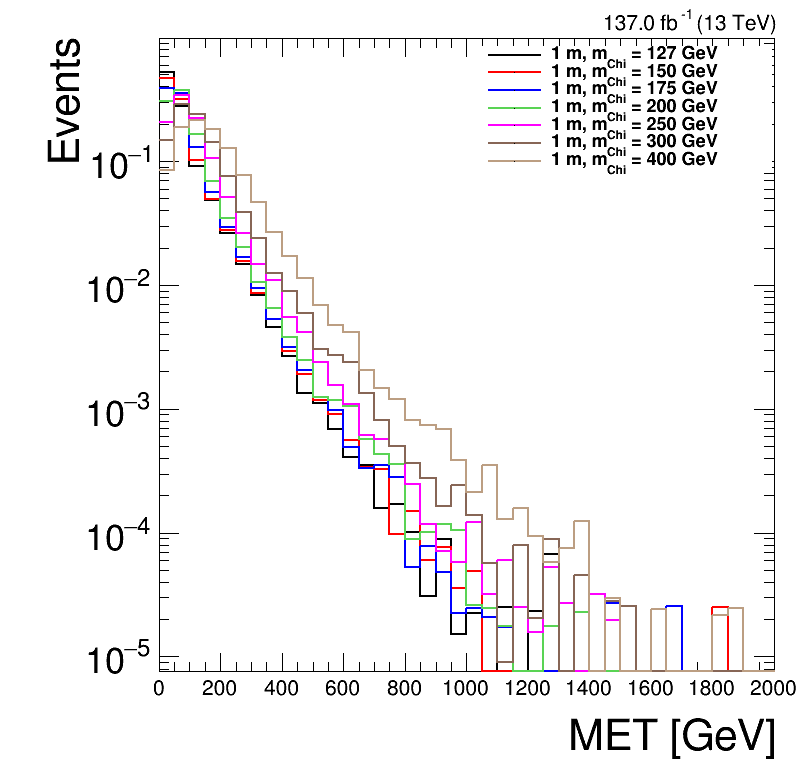

In [87]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = trg_jet_met[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['MET [GeV]', 'Events']
    bin_set = [40,0,2000]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
#     ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
    ht[k].DrawNormalized("hist same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='MET_shape.png'
c.SaveAs(plotDir+outf)    
    

# 2D met vs h pt

127 <TTree b'SusyLLPSigEffTree' at 0x7f122524ddd8>
111260
111260
111260
111260
127 1
137.0 fb^{-1} (13 TeV)
127
150 <TTree b'SusyLLPSigEffTree' at 0x7f121b272ba8>
107258
107258
107258
107258
150 2
137.0 fb^{-1} (13 TeV)
150
175 <TTree b'SusyLLPSigEffTree' at 0x7f121b2e7470>
102486
102486
102486
102486
175 4
137.0 fb^{-1} (13 TeV)
175
200 <TTree b'SusyLLPSigEffTree' at 0x7f121b3a4dd8>
99830
99830
99830
99830
200 8
137.0 fb^{-1} (13 TeV)
200
250 <TTree b'SusyLLPSigEffTree' at 0x7f1224dcd630>
96150
96150
96150
96150
250 6
137.0 fb^{-1} (13 TeV)
250
300 <TTree b'SusyLLPSigEffTree' at 0x7f121b38beb8>
92198
92198
92198
92198
300 28
137.0 fb^{-1} (13 TeV)
300
400 <TTree b'SusyLLPSigEffTree' at 0x7f121b1f67f0>
87702
87702
87702
87702
400 43
137.0 fb^{-1} (13 TeV)
400


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/2D_MET_HPt_mass127.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/2D_MET_HPt_mass150.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/2D_MET_HPt_mass175.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/2D_MET_HPt_mass200.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/2D_MET_HPt_mass250.png has been created
Warning in <TCanvas::Cons

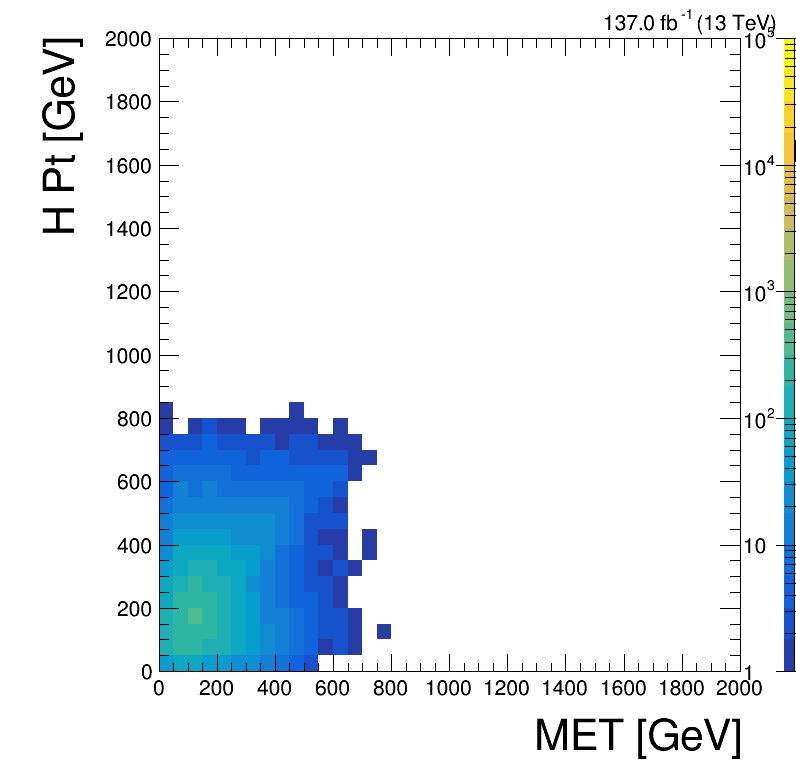

In [88]:
# h[k] = create_TH2D(np.transpose(np.row_stack((rechits_eta[k][index],rechits_phi[k][index]))), axis_title = ['#eta','#phi','Events'], binning=bins)

# Plotting  
from ROOT import gStyle
from ROOT import gROOT
from ROOT import TStyle

gROOT.SetBatch(1)
gStyle.SetPaintTextFormat(".2f")
gStyle.SetOptStat(0)
# gStyle.SetOptStat(1111)



color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    
    var_x = trg_jet_met[k]
    var_x = np.array([[x,x] for x in var_x])
    var_x = var_x.flatten()
    
    h_str = np.logical_and(1, trg_jet_hid[k]==25)
    var_y = trg_jet_hpt[k][h_str]
    
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    
    print(len(var_x))
    print(len(var_y))
    print(len(ws))
    
    axis_set = ['MET [GeV]', 'H Pt [GeV]','Events']
    bin_set = [40,0,2000, 40,0,2000]
    lumi=137000
    
#     var = np.row_stack((var_x, var_y))
    var = np.transpose(np.row_stack((var_x, var_y)))
    
    print(len(var))
    
    ht[k] = create_TH2D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
#     ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.03)
    ht[k].GetZaxis().SetLabelSize(0.03)
    ht[k].GetZaxis().SetLabelOffset(-0.07)
    ht[k].GetZaxis().SetTitleOffset(0.)
#     ht[k].GetZaxis().SetRangeUser(1,1e+5)
    ht[k].SetMinimum(1)
    ht[k].SetMaximum(1e+5)
#     ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
#     ht[k].Draw("COLZ surf1zfb ")
    ht[k].Draw("COLZ")
#     ht[k].Draw("cont3 same")
#     leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.07)
    # c.SetLogy()
    c.SetLogz()
    c.Draw()
    print(k)
    outf='2D_MET_HPt_mass'+str(k)+'.png'
    c.SaveAs(plotDir+outf)    
    

# Signal Yields

In [28]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Event Yield', 'Event Yield Error', 'Event Yield [MET > 200 GeV]', 'Event Yield Error[MET > 200 GeV]', 'SigEff [%]' ])
for k,v in tree.items():

    lumi=137000

    EventALLW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
    EventALLWsq = [x*x  for x in EventALLW]
    EventW = [x*y for x,y in zip(trg_jet_w[k][trg_jet_met[k]>200],trg_jet_puw[k][trg_jet_met[k]>200])]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventALLW)*lumi, 2), round(math.sqrt(np.sum(EventALLWsq))*lumi, 2),round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2), round( 1*(np.sum(EventW)/np.sum(EventALLW)), 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------------+-------------+-------------------+-----------------------------+----------------------------------+------------+
| Sample |      Weight     | Event Yield | Event Yield Error | Event Yield [MET > 200 GeV] | Event Yield Error[MET > 200 GeV] | SigEff [%] |
+--------+-----------------+-------------+-------------------+-----------------------------+----------------------------------+------------+
|  127   | [5.6951445e-05] |  453232.53  |      2049.05      |           27707.97          |              505.6               |    0.06    |
|  150   | [2.1877613e-05] |  167709.73  |       772.45      |           11067.93          |              198.68              |    0.07    |
|  175   | [1.5398517e-05] |  112791.67  |       531.07      |           7917.73           |              140.75              |    0.07    |
|  200   |  [8.116029e-06] |   57939.51  |       276.45      |           4823.42         

In [29]:
table_txt = table.get_string()
# with open(plotDir+'/1m_MET200_Eff.txt','w') as file:
with open(plotDir+'/Trg310_1m_MET200_Eff.txt','w') as file:
    file.write(table_txt)

# Reweight check

In [8]:
# trg_path=310
# trg_path=467
# met_cut=200
met_cut=0

#no met cut, no trg


trg_jet_met = {}

trg_jet_ctau = {}

trg_jet_w = {} 
trg_jet_puw = {} 



for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()

    hlt = v['HLTDecision'].array()[:,trg_path]


    #gLLP
    llp_ctau = v['gLLP_ctau'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    


    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(met>met_cut, met>met_cut)    

#     met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_hlt_triggered)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    
    trg_jet_w[k] = weight[met_trg_str]
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]




    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))


200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
(55819,)
49915
49915


In [10]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , ' Yield', 'Error'])
for k,v in tree.items():
 
    lumi=137000
 
    EventW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+----------------+----------+--------+
| Sample |     Weight     |   Yield  | Error  |
+--------+----------------+----------+--------+
|  200   | [8.116029e-06] | 57939.51 | 276.45 |
+--------+----------------+----------+--------+


In [9]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

In [22]:
# OLD_CTAU=10000 #mm
# ctaus=np.array([1000])

OLD_CTAU=1000 #mm
ctaus=np.array([100])

EventReW = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k]  ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] =  trg_jet_w[k]*weight_ctau*trg_jet_puw[k] 


200
ctau 100  mm


In [23]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', ' Yield', 'Error'])
for k,v in tree.items():
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReW[k][ct])*lumi), 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------+----------+--------+
| Sample | Ctau [mm] |   Yield  | Error  |
+--------+-----------+----------+--------+
|  200   |    100    | 62961.37 | 250.92 |
+--------+-----------+----------+--------+


200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
200 1
 FCN=140.33 FROM MIGRAD    STATUS=CONVERGED      48 CALLS          49 TOTAL
                     EDM=1.82847e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.61196e+00   7.07043e-03   2.77428e-05   3.97459e-02
   2  Slope       -1.03217e-02   5.34589e-05   2.09757e-07   3.46059e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/CTAU_original.png has been created


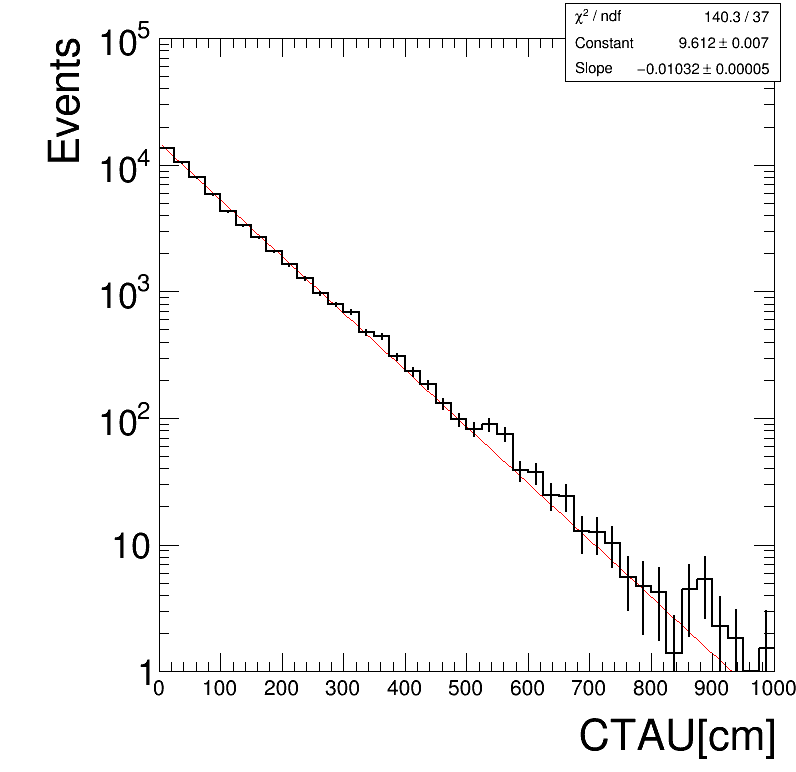

In [28]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = trg_jet_ctau[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['CTAU[cm]', 'Events']
    bin_set = [40,0,1000]
    lumi=137000
    
    ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+5)
    ht[k].Fit('expo')
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

# leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='CTAU_original.png'
c.SaveAs(plotDir+outf)    
    

200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
200 1
 FCN=112.926 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=1.7408e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.22775e+01   1.58204e-02   6.52172e-05  -3.35955e-03
   2  Slope       -1.01441e-01   1.04887e-04   4.32403e-07   8.47058e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/CTAU_reweight.png has been created


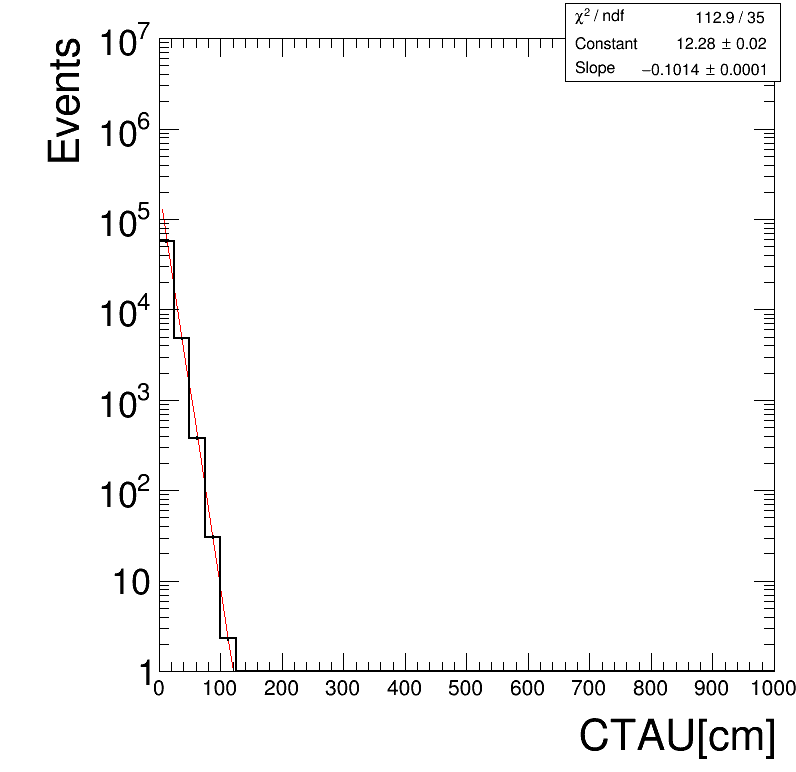

In [31]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    

    var = trg_jet_ctau[k]
    for ct in ctaus:
        ws = EventReW[k][ct]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+7)
        ht[k].Fit('expo')
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    # CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    # CMS_lumi.cmsText = ""
    # CMS_lumi.writeExtraText = False
    # CMS_lumi.CMS_lumi(c,4,3)

    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    outf='CTAU_reweight.png'
    c.SaveAs(plotDir+outf)    


200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
200 1
200 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: 200 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/CTAU_com.png has been created


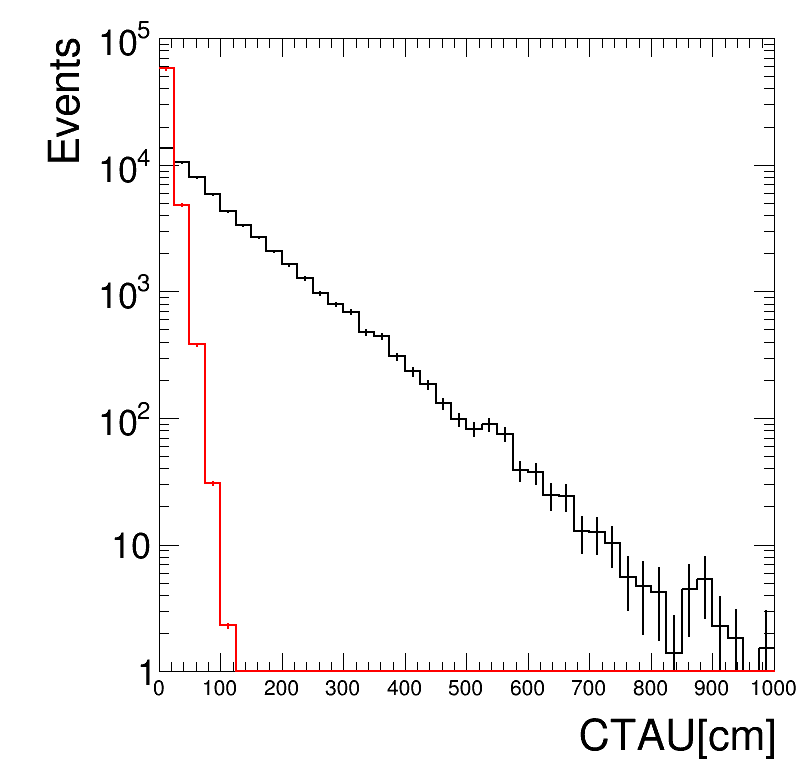

In [34]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
hk = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    #original
    var = trg_jet_ctau[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['CTAU[cm]', 'Events']
    bin_set = [40,0,1000]
    lumi=137000
    
    hk[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    hk[k].SetLineColor(std_color_list[i])
    hk[k].GetXaxis().SetLabelSize(0.03)
    hk[k].GetYaxis().SetRangeUser(1,1e+5)
#     hk[k].Fit('expo')
    print(k, std_color_list[i])
    hk[k].Draw("hist E same") 
    
    i+=1
    #reweight    
    var = trg_jet_ctau[k]
    for ct in ctaus:
        ws = EventReW[k][ct]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+7)
#         ht[k].Fit('expo')
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

 
    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    outf='CTAU_com.png'
    c.SaveAs(plotDir+outf)    
